In [1]:
# # Import necessary libraries

# Standard Python library
import gzip
import os
import random
import shutil
import time
import urllib.request
from collections import Counter

# Third-party libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from dotenv import load_dotenv
from intervaltree import IntervalTree

# Scikit-Learn - Core ML Functionality 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import hamming_loss, f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier

# Transformers - Pretained BERT models and retraining functions
from transformers import BertTokenizer, BertModel, Trainer, TrainingArguments, BertForTokenClassification
from accelerate import Accelerator

# BioPython - NCBI Data Processing and API
from Bio import SeqIO
from Bio import Entrez
from Bio.SeqFeature import CompoundLocation


c:\Users\musti\Documents\GitHub\Bacterial-Gene-Identification-ML-Model\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# # Change these settings based on use case:

# Use Entrez API to search NCBI for and downlaod genomes
useEntrez = False
maxResults = 10
# True if files already present, false if using remote access via Entrez
directDownload = True
# Directory to store downloaded GBFF files
outDirectory = "../data/downloads"
# True if testing basic DNABERT on data (it sucks)
testbasic = False


In [3]:
# # Create a query and download maxResults GBFF files from NCBI's Assembly database using Entrez API

def searchNcbiAssembly(searchTerm, max):
    """Search NCBI for all bacterial genomes matching the criteria."""
    handle = Entrez.esearch(db="assembly", term=searchTerm, retmax=max)
    record = Entrez.read(handle)
    handle.close()
    
    if record["IdList"]:
        return record["IdList"]  # List of Assembly IDs
    else:
        print("No bacterial genomes found.")
        return []

if useEntrez:
    # Load variables from .env file
    load_dotenv()

    # # Verify they are loaded
    # print("NCBI Email:", Entrez.email)
    # print("NCBI API Key:", Entrez.api_key)

    # Set Entrez API credentials
    Entrez.email = os.getenv("NCBI_EMAIL", None)
    Entrez.api_key = os.getenv("NCBI_API_KEY", None)

    os.makedirs(outDirectory, exist_ok=True)

    # Search term to retrieve annotated bacterial genomes
    searchTerm = '"Bacteria"[Organism] AND "Complete Genome"[AssemblyStatus] AND "latest_refseq"[PropertyList] AND "refseq_has_annotation"[PropertyList] AND "reference genome"[RefSeqCategory]'

    # Get list of bacterial genome assembly IDs
    assemblyIDs = searchNcbiAssembly(searchTerm, maxResults)
    print(assemblyIDs)
else:
    print("Project set to skip use of Entrez API; check that files are already in /data/downloads folder")


Project set to skip use of Entrez API; check that files are already in /data/downloads folder


In [4]:
# # Download each bacterial genome from list of assembly IDs

def getGbffUrl(id):
    """Retrieve the FTP URL for downloading the GBFF file."""
    handle = Entrez.esummary(db="assembly", id=id, retmode="xml")
    record = Entrez.read(handle)
    handle.close()

    try:
        ftpPath = record["DocumentSummarySet"]["DocumentSummary"][0]["FtpPath_RefSeq"]
        if not ftpPath:  # If RefSeq is not available, get GenBank version
            # print(f"Skipping {id} (No RefSeq available, only GenBank).")
            # return None
            ftpPath = record["DocumentSummarySet"]["DocumentSummary"][0]["FtpPath_GenBank"]
            if not ftpPath:
                print(f"No FTP path found for assembly {id}")
                return None

        # Construct GBFF file URL
        filename = ftpPath.split("/")[-1] + "_genomic.gbff.gz"
        url = f"{ftpPath}/{filename}"
        return url

    except Exception as e:
        print(f"Error retrieving FTP URL: {e}")
        return None
    
    
def downloadGbffFile(url, outFile):
    """Download the GBFF file from the provided FTP URL."""
    try:
        urllib.request.urlretrieve(url, outFile)
        print(f"Downloaded: {outFile}")
    except Exception as e:
        print(f"Failed to download {url}: {e}")
        
if useEntrez:
    for ID in assemblyIDs:
        URL = getGbffUrl(ID)
        if URL:
            outFile = os.path.join(outDirectory, f"{ID}.gbff.gz")
            downloadGbffFile(URL, outFile)
        
        # Avoid exceeding NCBI rate limits
        time.sleep(1)
else:
    print("Project set to skip use of Entrez API; check that files are already in /data/downloads folder")


Project set to skip use of Entrez API; check that files are already in /data/downloads folder


In [5]:
# # Extract GBFF contents from downloaded .gbff.gz files

def extractFiles(directory):
    """Extract all .gbff.gz files in the directory."""
    for filename in os.listdir(directory):
        if filename.endswith(".gbff.gz"):
            gzPath = os.path.join(directory, filename)
            gbffPath = os.path.join(directory, filename.replace(".gz", ""))

            try:
                # Extract .gbff.gz to .gbff
                with gzip.open(gzPath, "rb") as f_in:
                    with open(gbffPath, "wb") as f_out:
                        shutil.copyfileobj(f_in, f_out)

                print(f"Extracted: {gbffPath}")

                # Delete the .gz file after extraction
                os.remove(gzPath)

            except Exception as e:
                print(f"Failed to extract {gzPath}: {e}")

# Run extraction
extractFiles(outDirectory)


In [6]:
# # Process downloaded GBFF files for model input and/or fine-tuning/pretraining
# # Most of the captured info is setup for downstream tasks, not necessarily within
# # project's scope

dataDirectory = "../data/downloads"

validGeneTypes = ["CDS", "rRNA", "tRNA", "ncRNA", "tmRNA", "misc_RNA"]
validOtherTypes = ["regulatory", "protein_bind", "mobile_element"]

# Optional for downstream tasks:
essentialGenomeElements = [
    "Sequence", "GenomeType", "Genes",
]
essentialGeneElements = [
    "GeneType", "LocusTag", "Start", "End", "GeneLength", "Strand", 
    "IntergenicDistance", "GCContent", "Organism", "RegulatoryClass", 
    "BoundMoiety", "Serovar", "Strain", "Subspecies"
]
OptionalGeneElements = ["GeneName"]

# Examples:
# Gene types:
# ['source', 'gene', 'CDS', 'regulatory', 'protein_bind', 'rRNA', 'tRNA', 'ncRNA', 'mobile_element', 'tmRNA', 'misc_RNA']

# Qualifiers:
# {
#     'organism': ['Salmonella enterica subsp. enterica serovar Typhimurium str. LT2'], 
#     'mol_type': ['genomic DNA'], 
#     'strain': ['LT2'], 
#     'serovar': ['Typhimurium'], 
#     'sub_species': ['enterica'], 
#     'culture_collection': ['ATCC:700720', 'SGSC:1412'], 
#     'type_material': ['type strain of Salmonella enterica'], 
#     'db_xref': ['taxon:99287'], 
#     'focus': [''],
#     'plasmid': ['pSLT']
# }
if directDownload:
    data = []
    for i, filename in enumerate(os.listdir(dataDirectory)):
        print(f"processing File {i}: {filename}")
        if filename.endswith(".gbff"):
            fullPath = os.path.join(dataDirectory, filename)
            # Read the file and parse it as a GenBank record
            with open(fullPath, "r") as input:
                for record in SeqIO.parse(input, "genbank"):
                    accessionNum = record.id
                    genome = record.seq
                    genomeLength = len(genome)
                    description = record.description
                    genomeType = "plasmid" if "plasmid" in description.lower() else "chromo"

                    # print(f"Accession: {record.id}")
                    # print(f"Genome Length: {genomeLength} bp")
                    # print(f"Type of genome: {genomeType}")
                    # print(f"Description: {description}")

                    # Store all `source` regions
                    source_regions = []
                    for gene in record.features:
                        if gene.type == "source":
                            source_info = {
                                "organism": gene.qualifiers.get("organism", ["Unknown"])[0],
                                "mol_type": gene.qualifiers.get("mol_type", ["Unknown"])[0],
                                "location": gene.location,  # May be CompoundLocation
                                "strain": gene.qualifiers.get("strain", ["Unknown"])[0],
                                "serovar": gene.qualifiers.get("serovar", ["Unknown"])[0],
                                "sub_species": gene.qualifiers.get("sub_species", ["Unknown"])[0],
                            }
                            source_regions.append(source_info)

                    genes = []
                    for gene in record.features:
                        organism = None
                        subspecies = None
                        moleculeType = None
                        strain = None
                        serovar = None

                        geneType = gene.type
                        if geneType not in validGeneTypes + validOtherTypes:
                            continue  # Skip unwanted feature types
                        geneName = None
                        locusTag = None
                        geneStart = gene.location.start
                        geneEnd = gene.location.end
                        strand = "+" if gene.location.strand == 1 else "-"
                        labelsForGenePresence = genome[geneStart:geneEnd]
                        GCContent = (labelsForGenePresence.count("G") + labelsForGenePresence.count("C")) / len(labelsForGenePresence) if len(labelsForGenePresence) > 0 else 0

                        proteinProduct = None
                        aminoAcidSeq = None
                        regClass = None
                        boundMoiety = None
                        RNAProduct = None
                        ncRNAClass = None
                        elementType = None

                        if geneType == "mobile_element":
                            elementType = gene.qualifiers.get("mobile_element_type", ["Unknown"])[0]
                        elif geneType == "protein_bind":
                            boundMoiety = gene.qualifiers.get("bound_moiety", ["Unknown"])[0]
                        else:
                            geneName = gene.qualifiers.get("gene", ["Unknown"])[0]
                            locusTag = gene.qualifiers.get("locus_tag", ["Unknown"])[0]
                            # Extract protein-coding information
                            if geneType == "CDS":
                                proteinProduct = gene.qualifiers.get("product", ["Unknown"])[0]
                                aminoAcidSeq = gene.qualifiers.get("translation", ["Unknown"])[0]
                            elif geneType == "regulatory":
                                regClass = gene.qualifiers.get("regulatory_class", ["Unknown"])[0]
                            elif geneType == "ncRNA":
                                ncRNAClass = gene.qualifiers.get("ncRNA_class", ["Unknown"])[0]
                            elif geneType != "gene":
                                RNAProduct = gene.qualifiers.get("product", ["Unknown"])[0]
                        
                        # Check which `source` the gene belongs to
                        for source in source_regions:
                            sourceLocation = source["location"]

                            # If `source_location` is compound, check each part
                            if isinstance(sourceLocation, CompoundLocation):
                                for subregion in sourceLocation.parts:
                                    if geneStart in subregion:  # Gene is inside a main genome section
                                        organism = source["organism"]
                                        subspecies = source["sub_species"]
                                        moleculeType = source["mol_type"]
                                        strain = source["strain"]
                                        serovar = source["serovar"]
                                        break
                            else:
                                if geneStart in sourceLocation:  # Gene is inside a simple (non-compound) source
                                    organism = source["organism"]
                                    subspecies = source["sub_species"]
                                    moleculeType = source["mol_type"]
                                    organism = source["organism"]
                                    moleculeType = source["mol_type"]
                                    strain = source["strain"]
                                    serovar = source["serovar"]
                                    break

                        previousGeneEnd = None
                        for prevGene in reversed(genes):  # Search backward
                            if prevGene["Strand"] == strand and prevGene["Organism"] == organism:  # Only consider same-strand genes from same source
                                previousGeneEnd = prevGene["End"]
                                break
                        intergenicDistance = geneStart - previousGeneEnd if previousGeneEnd is not None else None
                        # print(f"Gene: {geneName}, Location: {geneStart}-{geneEnd}, Strand: {strand}")

                        # Store extracted features
                        genes.append({
                            "Organism": organism,
                            "Subspecies": subspecies,
                            "MoleculeType": moleculeType,
                            "Strain": strain,
                            "Serovar": serovar,
                            "GeneType": geneType,
                            "GeneName": geneName,
                            "LocusTag": locusTag,
                            "Start": geneStart,
                            "End": geneEnd,
                            "Strand": strand,
                            "GeneLength": len(labelsForGenePresence),
                            "GCContent": GCContent,
                            "ElementType": elementType,
                            "BoundMoiety": boundMoiety,
                            "ProteinProduct": proteinProduct,
                            "AminoAcidSeq": aminoAcidSeq,
                            "RegulatoryClass": regClass,
                            "ncRNAClass": ncRNAClass,
                            "RNAProduct": RNAProduct,
                            "IntergenicDistance": intergenicDistance,
                        })
                    data.append({
                        "Accession": accessionNum,
                        "GenomeLength": genomeLength,
                        "Sequence": genome,
                        "Description": description,
                        "GenomeType": genomeType,
                        "Genes": genes
                    })
    print(f"Total number of sequences: {len(data)}")

else:
    print("Project set to use remote fetching via Entrez API; this section skipped")


processing File 0: 71720138.gbff
processing File 1: 71720458.gbff
processing File 2: 71759168.gbff
processing File 3: 71759988.gbff
processing File 4: 71805988.gbff
processing File 5: 71806308.gbff
processing File 6: 71844268.gbff
processing File 7: 71848628.gbff
processing File 8: 72082058.gbff
processing File 9: 72083138.gbff
processing File 10: Salmonella.gbff
processing File 11: tuberculosis.gbff
Total number of sequences: 28


In [7]:
# Needs rework!!!
# # Fetch sequence and annotation data remotely

def getAssemblyAccessionID(id):
    """Retrieve the assembly accession ID for a genome assembly."""
    handle = Entrez.esummary(db="assembly", id=id, retmode="xml")
    record = Entrez.read(handle)
    handle.close()

    try:
            # Extract GenBank nucleotide accession (used in nuccore)
            document = record["DocumentSummarySet"]["DocumentSummary"][0]
            accession = document["AssemblyAccession"]  # Use GenBank ID for nuccore

            if not accession:
                print(f"No nucleotide accession found for assembly {id}")
                return None

            return accession

    except KeyError:
        print(f"Failed to retrieve accession for {id}")
        return None

def getNuccoreAccessionID(accession):
    """Retrieve the nucleotide accession ID for a genome assembly."""
    handle = Entrez.esearch(db="nuccore", term=accession, retmode="xml")
    record = Entrez.read(handle)
    handle.close()

    # Extract the first valid nucleotide accession
    if record["IdList"]:
        return record["IdList"][0]
    else:
        print(f"No nucleotide accession found for {accession}")
        return None
    
def fetchGbffData(accession):
    """Fetch GBFF data for a genome assembly accession without downloading a file."""
    handle = Entrez.efetch(db="nuccore", id=accession, rettype="gbwithparts", retmode="text")
    records = list(SeqIO.parse(handle, "genbank"))
    handle.close()
    
    return records  # Returns a list of GenBank records

if not directDownload:
    for ID in assemblyIDs:
        print(f"Processing Assembly ID: {ID}")
        assemblyAccession = getAssemblyAccessionID(ID)
        print(f"Assembly Accession: {assemblyAccession}")
        if not assemblyAccession:
            print("Skipping due to missing assembly accession.")
            continue

        # Avoid exceeding NCBI rate limits
        time.sleep(1)

        nucAccession = getNuccoreAccessionID(assemblyAccession)
        print(f"Nucleotide Accession: {nucAccession}")
        if not nucAccession:
            print("Skipping due to missing nucleotide accession.")
            continue

        # Avoid exceeding NCBI rate limits
        time.sleep(1)

        try:
            gbffData = fetchGbffData(nucAccession)
        except Exception as e:
            print(f"Failed to fetch GBFF data for {nucAccession}: {e}")
            continue
        
        # Avoid exceeding NCBI rate limits
        time.sleep(1)

        # Print summary of first record
        if gbffData:
            print(f"Accession: {gbffData[0].id}")
            print(f"Description: {gbffData[0].description}")
            print(f"Sequence Length: {len(gbffData[0].seq)} bp")
            
            # Print first few genes
            for gene in gbffData[0].features[:5]:  
                print(f"Feature Type: {gene.type}, Location: {gene.location}")
else:
    print("Project set to direct download; this section skipped.")


Project set to direct download; this section skipped.


In [8]:
# # Check GPU availability
if testbasic:
    print(torch.__config__.show())
    print("PyTorch version:", torch.__version__)
    print("CUDA available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("GPU Count:", torch.cuda.device_count())
        print("GPU Name:", torch.cuda.get_device_name(0))
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    print(f"Device: {device}")
else:
    print("Project set to skip testing basic pretrained DNABERT model; this section skipped.")


Project set to skip testing basic pretrained DNABERT model; this section skipped.


In [9]:
# # Initialize DNABert
if testbasic:
    # Load the DNABert tokenizer and model (pretrained 6-mer model)
    tokenizer = BertTokenizer.from_pretrained("zhihan1996/DNA_bert_6", do_lower_case=False)
    model = BertTokenizer.from_pretrained("zhihan1996/DNA_bert_6", num_labels=2)

    if device == "cuda":
        model = model.to(device)
else:
    print("Project set to skip testing basic pretrained DNABERT model; this section skipped.")


Project set to skip testing basic pretrained DNABERT model; this section skipped.


In [10]:
# # Subset and truncate input sequences to workable sizes
if testbasic:
    numSequences = 1
    truncateLength = 100000
    dataSubset = []

    if numSequences <= len(data): # Randomly picks numSequences genomes from the input list
        for i in range(numSequences):
            randIdx = random.randint(0, len(data) - 1)
            while data[randIdx] in dataSubset:
                randIdx = random.randint(0, len(data) - 1)

            if len(data[randIdx]["Sequence"]) > truncateLength: # Truncate sequences longer than truncateLength bp, may extend for greater accuracy
                print(f"Truncated sequence {randIdx}")
                data[randIdx]["Sequence"] = data[randIdx]["Sequence"][0:truncateLength - 1]
                for gene in data[randIdx]["Genes"]: # Remove genes on deleted part of sequence
                    if gene["Start"] > truncateLength  or gene["End"] > truncateLength:
                        data[randIdx]["Genes"].remove(gene)
            dataSubset.append(data[randIdx])
            print(f"{randIdx}: {len(dataSubset[i]["Sequence"])}")
else:
    print("Project set to skip testing basic pretrained DNABERT model; this section skipped.")


Project set to skip testing basic pretrained DNABERT model; this section skipped.


In [11]:
# # Rough idea of gene type distribution for each genome
if testbasic:
    allTypes = validGeneTypes + validOtherTypes
    allTotal = 0
    for s, sequence in enumerate(dataSubset):
        geneCounter = Counter()
        for i, gene in enumerate(sequence["Genes"]):
            geneCounter[gene["GeneType"]] += 1
        total = sum(geneCounter.values())
        print(f"Sequence {s + 1}:")
        for geneType in allTypes:
            print(f"  {geneType}: {geneCounter[geneType]}")
        print(f"Total genes: {total}\n")
        allTotal += total
    print(f"Final Total genes: {allTotal}\n")
else:
    print("Project set to skip testing basic pretrained DNABERT model; this section skipped.")


Project set to skip testing basic pretrained DNABERT model; this section skipped.


In [12]:
# # Create labels and embeddings for gene identification and classification for each genome

def extractGeneLocations(record):
    """
    Extracts start and end positions of all genes in a GBFF record.

    record: Actual genome record with organism info + genes list

    Returns list of 3-tuples with gene ranges and their types.
    """
    geneRanges = []
    for gene in record["Genes"]:
        start = int(gene["Start"])
        end = int(gene["End"])
        type = gene["GeneType"]
        geneRanges.append((start, end, type))

    return geneRanges

def buildTreeForGenePresence(geneRanges):
    """
    Builds an interval tree that stores gene presence for fast gene lookup.
    
    geneRanges: List of 3-tuples in the form (start, end, geneType)

    Returns IntervalTree with base pair intervals marked 1 if a gene exist, 
    0 otherwise.
    """
    tree = IntervalTree()

    for start, end, geneType in geneRanges:
        tree[start:end] = 1  # Store a value (1) to mark gene presence

    return tree

def buildTreeForGeneType(geneRanges):
    """
    Builds an interval tree that stores gene type info per interval.

    geneRanges: List of 3-tuples in the form (start, end, geneType)

    Returns IntervalTree with base pair interval sets containing 
    string names of overlapping gene types.
    """
    tree = IntervalTree()
    
    for start, end, geneType in geneRanges:
        overlapping = tree[start:end]

        if overlapping:
            # Remove old and replace with merged intervals
            tree.chop(start, end)  # Cut out overlapping region
            tree[start:end] = {geneType}
            for interval in overlapping:
                overlap_start = max(start, interval.begin)
                overlap_end = min(end, interval.end)
                combined_data = set(interval.data) | {geneType}
                tree[overlap_start:overlap_end] = combined_data
        else:
            tree[start:end] = {geneType}

    return tree

def chunkRawSequence(sequence, windowSize=512 * 6, stride=256 * 6):
    '''
    Convert long sequence into overlapping chunks of (512 * 6 by default) base pairs.

    sequence (string): Raw genome sequence
    windowSize (int): Width of window for input into model (512 * 6 for 512 6-mers)
    stride (int): Amount of overlap between windows

    Returns list of overlapping window strings of length len(sequence) - windowSize + 1.
    '''
    return [sequence[i:i+windowSize] for i in range(0, len(sequence) - windowSize + 1, stride)]

def labelSequenceChunk(startOffset, numKmers, k=6, treePresence=None, treeType=None):
    """
    Given a window of a sequence and its start offset in the original sequence,
    return gene presence and gene type labels for each k-mer in the window.

    startOffset (int): Base pair offset of current chunk
    numKmers (int): Total number of k-mers per chunk
    k (int): K-mer size (6-mers by default)
    treePresence: Reference to IntervalTree for gene presence/detection
    treeType: Reference to IntervalTree for gene type classification

    Returns tuple in the form (presenceLabels, typeLabels) where each element 
    is a list of int or set() labels respectively.
    """
    presenceLabels = []
    typeLabels = []

    for i in range(numKmers):
        kmerStart = startOffset + i
        kmerEnd = kmerStart + k

        # Gene Presence
        if treePresence:
            present = 1 if treePresence[kmerStart] else 0
            presenceLabels.append(present)

        # Gene Type
        if treeType:
            geneTypes = set()
            for interval in treeType[kmerStart:kmerEnd]:
                geneTypes.update(interval.data)
            typeLabels.append(geneTypes)

    return presenceLabels, typeLabels

if testbasic:
    kmersList = []
    embeddingsListForGenePresence = []
    embeddingsListForGeneType = []
    labelsListForGenePresence = []
    labelsListForGeneType = []

    k = 6
    numKmers = 512
    windowSize = numKmers * k # Gives 512 6-mers
    stride = 256

    for i, input in enumerate(dataSubset):
        print(f"Sequence {i + 1}:")
        sequence = str(input["Sequence"])
        # print(len(sequence))
        geneRanges = extractGeneLocations(input)
        # print(len(geneRanges))
        intervalTreeForGenePresence = buildTreeForGenePresence(geneRanges)
        intervalTreeForGeneType = buildTreeForGeneType(geneRanges)
        embeddingsChunkForGenePresence = []
        embeddingsChunkForGeneType = []
        windows = chunkRawSequence(sequence, windowSize, stride)
        if not windows:
            print(f"Sequence {i + 1} skipped — too short for window size {windowSize}. Length: {len(sequence)} bp")
            continue
        for j, window in enumerate(windows):
            # Convert k-mer list back to space-separated string to avoid dimensional issues
            kmers = [window[i:i+k] for i in range(0, len(window), k)]
            kmerString = " ".join(kmers)

            # Tokenize input
            inputs = tokenizer(kmerString, return_tensors='pt', padding=True, truncation=True)
            # print(inputs['input_ids'].shape)
            
            # Embed
            with torch.no_grad():
                outputs = model(**inputs)
            hiddenStates = outputs[0] # [1, sequence_length, 768]
            hiddenStates = hiddenStates.squeeze(0)
            
            # Embedding with mean pooling
            print(f"Sequence {i + 1} - Chunk {j + 1} out of {len(windows)} embedding shape: {hiddenStates.shape}") # expect to be 768

            # Generate labels for this window
            startbp = j * stride
            # Label per-k-mer based on interval tree and raw sequence position
            presenceLabels, typeLabels = labelSequenceChunk(
                startOffset=startbp,
                numKmers=numKmers,
                k=k,
                treePresence=intervalTreeForGenePresence,
                treeType=intervalTreeForGeneType
            )
            # print(len(presence_labels), len(type_labels))
            
            embeddingsChunkForGenePresence.append((hiddenStates, presenceLabels))
            embeddingsChunkForGeneType.append((hiddenStates, typeLabels))
        embeddingsListForGenePresence.append(embeddingsChunkForGenePresence)
        embeddingsListForGeneType.append(embeddingsChunkForGeneType)
        print("Finished!")
else:
    print("Project set to skip testing basic pretrained DNABERT model; this section skipped.")


Project set to skip testing basic pretrained DNABERT model; this section skipped.


In [13]:
# # Plot first 2 embeddings for pattern visualization - Clusters show patterns recognized by DNABert
if testbasic:
    for sequence in embeddingsListForGenePresence:
        for i, (embeds, labels) in enumerate(sequence):
            # Convert list to numpy array for t-SNE
            embeddingsNpArray = np.vstack(embeds)

            # Reduce to 2D using t-SNE
            tsne = TSNE(n_components=2, perplexity=5, random_state=42)
            embeddings2d = tsne.fit_transform(embeddingsNpArray)

            # Plot
            plt.figure(figsize=(8, 5))
            plt.scatter(embeddings2d[:, 0], embeddings2d[:, 1], alpha=0.6, cmap="viridis")
            plt.title(f"t-SNE Visualization of DNABert Embeddings (Sequence {i+1})")
            plt.xlabel("t-SNE Component 1")
            plt.ylabel("t-SNE Component 2")
            plt.colorbar()
            plt.show()

            if i == 1:
                break
else:
    print("Project set to skip testing basic pretrained DNABERT model; this section skipped.")


Project set to skip testing basic pretrained DNABERT model; this section skipped.


In [14]:
# # Examine label counts

# Presence labels structure:            Type labels structure:
# [                                     [
#   [                                       [
#       (                                       (
#           [512,768]                               [512,768]
#        ,                                       ,
#           [1, 0, 1, ...]                          [set("CDS"), set("CDS", "tRNA"), set(), ...]
#       ),                                      ),
#   ],                                      ],
# ]                                     ]
#       
if testbasic:
    for j, sequence in enumerate(embeddingsListForGenePresence):
        total1s = 0
        total0s = 0
        for i, (embeds, labels) in enumerate(sequence):
            Zcount = 0
            Ocount = 0
            for label in labels:
                if label == 0:
                    Zcount += 1
                    total0s += 1
                if label == 1:
                    Ocount += 1
                    total1s += 1
            print(f"Chunk {i + 1}: 0s: {Zcount}, 1s: {Ocount}, Total: {Zcount + Ocount}")
        print(f"Sequence {j + 1}: 0s: {total0s}, 1s: {total1s}, Total: {total0s + total1s}")

    # validGeneTypes = ["CDS", "gene", "rRNA", "tRNA", "ncRNA", "tmRNA", "misc_RNA"]
    # validOtherTypes = ["regulatory", "protein_bind", "mobile_element"]
    allTypes = validGeneTypes + validOtherTypes
    for s, sequence in enumerate(embeddingsListForGeneType):
        typeCounter = Counter()
        for embeds, labels in sequence:
            for labelSet in labels:
                for geneType in labelSet:
                    if geneType in allTypes:
                        typeCounter[geneType] += 1
        total = sum(typeCounter.values())
        print(f"Sequence {s + 1}:")
        for geneType in allTypes:
            print(f"  {geneType}: {typeCounter[geneType]}")
        print(f"  Total labeled kmers: {total}\n")
else:
    print("Project set to skip testing basic pretrained DNABERT model; this section skipped.")


Project set to skip testing basic pretrained DNABERT model; this section skipped.


In [15]:
# # Train random forest on embeddings for gene detection to evaluate accuracy of predictions
if testbasic:
    X_genePresence = []  # features
    y_genePresence = []  # labels

    for sequence in embeddingsListForGenePresence:
        for embedChunk, labelChunk in sequence:
            for embed, label in zip(embedChunk, map(int, labelChunk)):
                X_genePresence.append(embed) # Embedding vectors for every k-mer
                y_genePresence.append(label) # Labels for every k-mer

    # Split and train
    X_trainPresence, X_testPresence, y_trainPresence, y_testPresence = train_test_split(X_genePresence, y_genePresence, stratify=y_genePresence, test_size=0.2, random_state=42)

    genePresenceClassifier = RandomForestClassifier(
        n_estimators=100,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    )
    genePresenceClassifier.fit(X_trainPresence, y_trainPresence)

    # Evaluate
    y_predPresence = genePresenceClassifier.predict(X_testPresence)
    accuracyGenePresence = accuracy_score(y_testPresence, y_predPresence)
    print(f"Actual Gene Presence: {Counter(y_genePresence)}")
    print(f"Gene Presence Prediction Accuracy: {accuracyGenePresence:.4f}")
    print("F1 Score:", f1_score(y_testPresence, y_predPresence))
    print(classification_report(y_testPresence, y_predPresence, zero_division=0))
    confusionMatrix = confusion_matrix(y_testPresence, y_predPresence)
    ConfusionMatrixDisplay(confusion_matrix=confusionMatrix).plot()
else:
    print("Project set to skip testing basic pretrained DNABERT model; this section skipped.")


Project set to skip testing basic pretrained DNABERT model; this section skipped.


In [16]:
# # Binarize labels for gene type and remove labels for gene types that never appear
if testbasic:
    X_geneType = []  # features
    y_geneType = []  # labels
    allLabels = []
    for sequence in embeddingsListForGeneType:
        for embedChunk, labelChunk in sequence:
            for embed, label in zip(embedChunk, labelChunk):
                X_geneType.append(embed) # Embedding vectors for every k-mer
                if label == set():
                    allLabels.append([])
                else:
                    allLabels.append(list(label))
                
    # Binarize labels for y
    multiHotBinarizer = MultiLabelBinarizer(classes=allTypes)  # Fix the class order
    multiHotLabels = multiHotBinarizer.fit_transform(allLabels)  # Shape: (umKmers, numTypes)

    # Step 1: Get label frequency for each class (column)
    labelCounts = np.sum(multiHotLabels, axis=0)
    # Step 2: Identify columns with at least one positive label
    nonzeroIndices = np.where(labelCounts > 0)[0]
    # Step 3: Filter the multi-hot labels
    multiHotLabels = multiHotLabels[:, nonzeroIndices]
    # Step 4: Filter the class labels to match
    multiHotBinarizer.classes_ = multiHotBinarizer.classes_[nonzeroIndices]

    y_geneType = multiHotLabels
else:
    print("Project set to skip testing basic pretrained DNABERT model; this section skipped.")


Project set to skip testing basic pretrained DNABERT model; this section skipped.


In [17]:
# # Train random forest on embeddings for gene classification to evaluate accuracy of predictions
if testbasic:
    # Split and train
    X_trainType, X_testType, y_trainType, y_testType = train_test_split(X_geneType, y_geneType, test_size=0.2, random_state=42)

    # Train classifier on gene types
    geneTypeClassifier = RandomForestClassifier(
        n_estimators=100,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    )
    geneTypeClassifier.fit(X_trainType, y_trainType)
    print("trained")
    # Evaluate
    y_predType = geneTypeClassifier.predict(X_testType)

    # Sum columns to count how many times each gene type appears
    geneTypeCounts = np.sum(y_geneType, axis=0)

    # Print nicely
    print("Actual Gene Types:")
    for geneType, count in zip(multiHotBinarizer.classes_, geneTypeCounts):
        print(f"  {geneType}: {int(count)}")

    print("Hamming Loss:", hamming_loss(y_testType, y_predType))
    print("Micro F1 Score:", f1_score(y_testType, y_predType, average='micro'))
    print("Macro F1 Score:", f1_score(y_testType, y_predType, average='macro'))
    print(classification_report(y_testType, y_predType, zero_division=0))
    for i, geneType in enumerate(multiHotBinarizer.classes_):
        confusionMatrix = confusion_matrix(y_testType[:, i], y_predType[:, i])
        disp = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=[f"Not {geneType}", geneType])
        disp.plot()
        plt.title(f"Confusion Matrix for {geneType}")
        plt.show()
else:
    print("Project set to skip testing basic pretrained DNABERT model; this section skipped.")


Project set to skip testing basic pretrained DNABERT model; this section skipped.


In [18]:
if testbasic:
    # Move original model to CPU
    model = model.to("cpu")  # move it off when not in use
    torch.cuda.empty_cache()
else:
    print("Project set to skip testing basic pretrained DNABERT model; this section skipped.")


Project set to skip testing basic pretrained DNABERT model; this section skipped.


In [55]:
# # Process downloaded GBFF files for model input and/or fine-tuning
# # Most of the captured info is setup for downstream tasks, not necessarily within
# # project's scope

dataDirectory = "../data/downloads"

validGeneTypes = ["CDS", "rRNA", "tRNA", "ncRNA", "tmRNA", "misc_RNA"]
validOtherTypes = ["regulatory", "protein_bind", "mobile_element"]

# Optional for downstream tasks:
essentialGenomeElements = [
    "Sequence", "GenomeType", "Genes",
]
essentialGeneElements = [
    "GeneType", "LocusTag", "Start", "End", "GeneLength", "Strand", 
    "IntergenicDistance", "GCContent", "Organism", "RegulatoryClass", 
    "BoundMoiety", "Serovar", "Strain", "Subspecies"
]
OptionalGeneElements = ["GeneName"]

# Examples:
# Gene types:
# ['source', 'gene', 'CDS', 'regulatory', 'protein_bind', 'rRNA', 'tRNA', 'ncRNA', 'mobile_element', 'tmRNA', 'misc_RNA']

# Qualifiers:
# {
#     'organism': ['Salmonella enterica subsp. enterica serovar Typhimurium str. LT2'], 
#     'mol_type': ['genomic DNA'], 
#     'strain': ['LT2'], 
#     'serovar': ['Typhimurium'], 
#     'sub_species': ['enterica'], 
#     'culture_collection': ['ATCC:700720', 'SGSC:1412'], 
#     'type_material': ['type strain of Salmonella enterica'], 
#     'db_xref': ['taxon:99287'], 
#     'focus': [''],
#     'plasmid': ['pSLT']
# }
if directDownload:
    data = []
    for i, filename in enumerate(os.listdir(dataDirectory)):
        print(f"processing File {i}: {filename}")
        if filename.endswith(".gbff"):
            fullPath = os.path.join(dataDirectory, filename)
            # Read the file and parse it as a GenBank record
            with open(fullPath, "r") as input:
                for record in SeqIO.parse(input, "genbank"):
                    accessionNum = record.id
                    genome = record.seq
                    genomeLength = len(genome)
                    description = record.description
                    genomeType = "plasmid" if "plasmid" in description.lower() else "chromo"

                    # print(f"Accession: {record.id}")
                    # print(f"Genome Length: {genomeLength} bp")
                    # print(f"Type of genome: {genomeType}")
                    # print(f"Description: {description}")

                    # Store all `source` regions
                    source_regions = []
                    for gene in record.features:
                        if gene.type == "source":
                            source_info = {
                                "organism": gene.qualifiers.get("organism", ["Unknown"])[0],
                                "mol_type": gene.qualifiers.get("mol_type", ["Unknown"])[0],
                                "location": gene.location,  # May be CompoundLocation
                                "strain": gene.qualifiers.get("strain", ["Unknown"])[0],
                                "serovar": gene.qualifiers.get("serovar", ["Unknown"])[0],
                                "sub_species": gene.qualifiers.get("sub_species", ["Unknown"])[0],
                            }
                            source_regions.append(source_info)

                    genes = []
                    for gene in record.features:
                        organism = None
                        subspecies = None
                        moleculeType = None
                        strain = None
                        serovar = None

                        geneType = gene.type
                        if geneType not in validGeneTypes + validOtherTypes:
                            continue  # Skip unwanted feature types
                        geneName = None
                        locusTag = None
                        geneStart = gene.location.start
                        geneEnd = gene.location.end
                        strand = "+" if gene.location.strand == 1 else "-"
                        labelsForGenePresence = genome[geneStart:geneEnd]
                        GCContent = (labelsForGenePresence.count("G") + labelsForGenePresence.count("C")) / len(labelsForGenePresence) if len(labelsForGenePresence) > 0 else 0

                        proteinProduct = None
                        aminoAcidSeq = None
                        regClass = None
                        boundMoiety = None
                        RNAProduct = None
                        ncRNAClass = None
                        elementType = None

                        if geneType == "mobile_element":
                            elementType = gene.qualifiers.get("mobile_element_type", ["Unknown"])[0]
                        elif geneType == "protein_bind":
                            boundMoiety = gene.qualifiers.get("bound_moiety", ["Unknown"])[0]
                        else:
                            geneName = gene.qualifiers.get("gene", ["Unknown"])[0]
                            locusTag = gene.qualifiers.get("locus_tag", ["Unknown"])[0]
                            # Extract protein-coding information
                            if geneType == "CDS":
                                proteinProduct = gene.qualifiers.get("product", ["Unknown"])[0]
                                aminoAcidSeq = gene.qualifiers.get("translation", ["Unknown"])[0]
                            elif geneType == "regulatory":
                                regClass = gene.qualifiers.get("regulatory_class", ["Unknown"])[0]
                            elif geneType == "ncRNA":
                                ncRNAClass = gene.qualifiers.get("ncRNA_class", ["Unknown"])[0]
                            elif geneType != "gene":
                                RNAProduct = gene.qualifiers.get("product", ["Unknown"])[0]
                        
                        # Check which `source` the gene belongs to
                        for source in source_regions:
                            sourceLocation = source["location"]

                            # If `source_location` is compound, check each part
                            if isinstance(sourceLocation, CompoundLocation):
                                for subregion in sourceLocation.parts:
                                    if geneStart in subregion:  # Gene is inside a main genome section
                                        organism = source["organism"]
                                        subspecies = source["sub_species"]
                                        moleculeType = source["mol_type"]
                                        strain = source["strain"]
                                        serovar = source["serovar"]
                                        break
                            else:
                                if geneStart in sourceLocation:  # Gene is inside a simple (non-compound) source
                                    organism = source["organism"]
                                    subspecies = source["sub_species"]
                                    moleculeType = source["mol_type"]
                                    organism = source["organism"]
                                    moleculeType = source["mol_type"]
                                    strain = source["strain"]
                                    serovar = source["serovar"]
                                    break

                        previousGeneEnd = None
                        for prevGene in reversed(genes):  # Search backward
                            if prevGene["Strand"] == strand and prevGene["Organism"] == organism:  # Only consider same-strand genes from same source
                                previousGeneEnd = prevGene["End"]
                                break
                        intergenicDistance = geneStart - previousGeneEnd if previousGeneEnd is not None else None
                        # print(f"Gene: {geneName}, Location: {geneStart}-{geneEnd}, Strand: {strand}")

                        # Store extracted features
                        genes.append({
                            "Organism": organism,
                            "Subspecies": subspecies,
                            "MoleculeType": moleculeType,
                            "Strain": strain,
                            "Serovar": serovar,
                            "GeneType": geneType,
                            "GeneName": geneName,
                            "LocusTag": locusTag,
                            "Start": geneStart,
                            "End": geneEnd,
                            "Strand": strand,
                            "GeneLength": len(labelsForGenePresence),
                            "GCContent": GCContent,
                            "ElementType": elementType,
                            "BoundMoiety": boundMoiety,
                            "ProteinProduct": proteinProduct,
                            "AminoAcidSeq": aminoAcidSeq,
                            "RegulatoryClass": regClass,
                            "ncRNAClass": ncRNAClass,
                            "RNAProduct": RNAProduct,
                            "IntergenicDistance": intergenicDistance,
                        })
                    data.append({
                        "Accession": accessionNum,
                        "GenomeLength": genomeLength,
                        "Sequence": genome,
                        "Description": description,
                        "GenomeType": genomeType,
                        "Genes": genes
                    })
    print(f"Total number of sequences: {len(data)}")

else:
    print("Project set to use remote fetching via Entrez API; this section skipped")


processing File 0: 71720138.gbff
processing File 1: 71720458.gbff
processing File 2: 71759168.gbff
processing File 3: 71759988.gbff
processing File 4: 71805988.gbff
processing File 5: 71806308.gbff
processing File 6: 71844268.gbff
processing File 7: 71848628.gbff
processing File 8: 72082058.gbff
processing File 9: 72083138.gbff
processing File 10: genomic_GCF_000007365.1.gbff
processing File 11: genomic_GCF_000007505.1.gbff
processing File 12: genomic_GCF_000007805.1.gbff
processing File 13: genomic_GCF_000007985.2.gbff
processing File 14: genomic_GCF_000010125.1.gbff
processing File 15: genomic_GCF_000010425.1.gbff
processing File 16: genomic_GCF_000011905.1.gbff
processing File 17: genomic_GCF_000012365.1.gbff
processing File 18: genomic_GCF_000014425.1.gbff
processing File 19: genomic_GCF_000015865.1.gbff
processing File 20: genomic_GCF_000083545.1.gbff
processing File 21: genomic_GCF_000091545.1.gbff
processing File 22: genomic_GCF_000146165.2.gbff
processing File 23: genomic_GCF_0

In [ ]:
# # Subset and truncate input sequences to workable sizes

numGenomes = len(data)
truncateLength = 10000000
dataSubset = []

if numGenomes <= len(data): # Randomly picks numGenomes genomes from the input list
    for i in range(numGenomes):
        randIdx = random.randint(0, len(data) - 1)
        while data[randIdx] in dataSubset:
            randIdx = random.randint(0, len(data) - 1)

        if len(data[randIdx]["Sequence"]) > truncateLength: # Truncate sequences longer than truncateLength bp, may extend for greater accuracy
            print(f"Truncated sequence {randIdx}")
            data[randIdx]["Sequence"] = data[randIdx]["Sequence"][0:truncateLength - 1]
            for gene in data[randIdx]["Genes"]: # Remove genes on deleted part of sequence
                if gene["Start"] > truncateLength  or gene["End"] > truncateLength:
                    data[randIdx]["Genes"].remove(gene)
        dataSubset.append(data[randIdx])
        print(f"{randIdx}: {len(dataSubset[i]["Sequence"])}")


81: 34568
14: 3399615
3: 44823
94: 7842
35: 2089645
31: 3814128
28: 6397126
17: 321572
13: 1194331
86: 40804
69: 2337763
11: 3884372
75: 3622107
54: 24853
4: 4719308
27: 1207381
29: 73661
64: 4748414
77: 1898076
71: 3357452
25: 641454
91: 73132
83: 73345
89: 3271838
53: 2762785
57: 2924929
103: 4586140
111: 93933
0: 3208966
97: 4498248
20: 52076
43: 38579
19: 2003
48: 161613
12: 3646165
45: 9322
108: 817125
44: 1849742
33: 38454
5: 104898
93: 46368
58: 26706
68: 4058311
15: 161663
10: 3397546
70: 5400144
37: 3809201
106: 1931548
80: 2049769
79: 4924764
110: 4857450
46: 256992
73: 2180101
24: 3606378
90: 32586
8: 5989031
84: 4492589
98: 2465028
109: 5892
47: 4969811
26: 2107794
85: 108549
34: 22870
87: 4588714
82: 5876902
9: 10647
21: 5016258
59: 1326
88: 57214
41: 5943768
107: 4610200
99: 29147
7: 9599576
105: 1953654
40: 3843301
51: 1171667
72: 147076
112: 4411532
63: 9106064
50: 1003404
18: 107656
95: 3803549
74: 2318657
65: 151583
96: 1886760
6: 151497
101: 2811859
76: 49266
49: 215

In [ ]:
# # Subset sequences further based on lowest prevalence of CDS genes for best distributions of the dataset
numSequences = 10
sortedData = []

allTypes = validGeneTypes + validOtherTypes
allTotal = 0
for s, sequence in enumerate(dataSubset):
    geneCounter = Counter()
    for i, gene in enumerate(sequence["Genes"]):
        geneCounter[gene["GeneType"]] += 1
    total = sum(geneCounter.values())
    sortedData.append((s, (geneCounter["CDS"] / total) * 100 if total > 0 else 0))
    print(f"Sequence {s + 1}:")
    for geneType in allTypes:
        print(f"  {geneType}: {(geneCounter[geneType] / total) * 100 if total > 0 else 0}")
    print(f"Total genes: {total}\n")
    allTotal += total
print(f"Final Total genes: {allTotal}\n")

if numSequences <= len(dataSubset): # Sorts sequences by CDS prevalence and only filters out all but least CDS-dominant
    sortedData = sorted(sortedData, key=lambda item: item[1])
    print(sortedData)
    keptIndices = []
    for i in range(numSequences):
        keptIndices.append(sortedData[i][0])
    print(keptIndices)

    dataSubset = [dataSubset[i] for i in keptIndices]
print(len(dataSubset))


Sequence 1:
  CDS: 47.11609694147529
  rRNA: 0.23282887077997672
  tRNA: 0.89956609164991
  ncRNA: 0.09524817440999048
  tmRNA: 0.010583130489998942
  misc_RNA: 0.0
  regulatory: 47.38067520372526
  protein_bind: 4.2015028045295795
  mobile_element: 0.06349878293999364
Total genes: 9449

Sequence 2:
  CDS: 83.33333333333334
  rRNA: 6.25
  tRNA: 10.416666666666668
  ncRNA: 0.0
  tmRNA: 0.0
  misc_RNA: 0.0
  regulatory: 0.0
  protein_bind: 0.0
  mobile_element: 0.0
Total genes: 96

Sequence 3:
  CDS: 93.96825396825396
  rRNA: 0.4761904761904762
  tRNA: 5.079365079365079
  ncRNA: 0.31746031746031744
  tmRNA: 0.15873015873015872
  misc_RNA: 0.0
  regulatory: 0.0
  protein_bind: 0.0
  mobile_element: 0.0
Total genes: 630

Sequence 4:
  CDS: 94.04953361209391
  rRNA: 1.5439047925377936
  tRNA: 3.21646831778707
  ncRNA: 0.0964940495336121
  tmRNA: 0.0321646831778707
  misc_RNA: 0.0
  regulatory: 1.061434544869733
  protein_bind: 0.0
  mobile_element: 0.0
Total genes: 3109

Sequence 5:
  CDS: 

In [62]:
# # Create labels and chunks for gene identification and classification for each genome

def extractGeneLocations(record):
    """
    Extracts start and end positions of all genes in a GBFF record.

    record: Actual genome record with organism info + genes list

    Returns list of 3-tuples with gene ranges and their types.
    """
    geneRanges = []
    for gene in record["Genes"]:
        start = int(gene["Start"])
        end = int(gene["End"])
        type = gene["GeneType"]
        geneRanges.append((start, end, type))

    return geneRanges

def buildTreeForGenePresence(geneRanges):
    """
    Builds an interval tree that stores gene presence for fast gene lookup.
    
    geneRanges: List of 3-tuples in the form (start, end, geneType)

    Returns IntervalTree with base pair intervals marked 1 if a gene exist, 
    0 otherwise.
    """
    tree = IntervalTree()

    for start, end, geneType in geneRanges:
        tree[start:end] = 1  # Store a value (1) to mark gene presence

    return tree

def buildTreeForGeneType(geneRanges):
    """
    Builds an interval tree that stores gene type info per interval.

    geneRanges: List of 3-tuples in the form (start, end, geneType)

    Returns IntervalTree with base pair interval sets containing 
    string names of overlapping gene types.
    """
    tree = IntervalTree()
    
    for start, end, geneType in geneRanges:
        overlapping = tree[start:end]

        if overlapping:
            # Remove old and replace with merged intervals
            tree.chop(start, end)  # Cut out overlapping region
            tree[start:end] = {geneType}
            for interval in overlapping:
                overlap_start = max(start, interval.begin)
                overlap_end = min(end, interval.end)
                combined_data = set(interval.data) | {geneType}
                tree[overlap_start:overlap_end] = combined_data
        else:
            tree[start:end] = {geneType}

    return tree

def chunkRawSequence(sequence, windowSize=512 * 6, stride=256 * 6):
    '''
    Convert long sequence into overlapping chunks of (512 * 6 by default) base pairs.

    sequence (string): Raw genome sequence
    windowSize (int): Width of window for input into model (512 * 6 for 512 6-mers)
    stride (int): Amount of overlap between windows

    Returns list of overlapping window strings of length len(sequence) - windowSize + 1.
    '''
    return [sequence[i:i+windowSize] for i in range(0, len(sequence) - windowSize + 1, stride)]

def labelSequenceChunk(startOffset, numKmers, k=6, treePresence=None, treeType=None):
    """
    Given a window of a sequence and its start offset in the original sequence,
    return gene presence and gene type labels for each k-mer in the window.

    startOffset (int): Base pair offset of current chunk
    numKmers (int): Total number of k-mers per chunk
    k (int): K-mer size (6-mers by default)
    treePresence: Reference to IntervalTree for gene presence/detection
    treeType: Reference to IntervalTree for gene type classification

    Returns tuple in the form (presenceLabels, typeLabels) where each element 
    is a list of int or set() labels respectively.
    """
    presenceLabels = []
    typeLabels = []

    for i in range(numKmers):
        kmerStart = startOffset + i
        kmerEnd = kmerStart + k

        # Gene Presence
        if treePresence:
            present = 1 if treePresence[kmerStart] else 0
            presenceLabels.append(present)

        # Gene Type
        if treeType:
            geneTypes = set()
            for interval in treeType[kmerStart:kmerEnd]:
                geneTypes.update(interval.data)
            typeLabels.append(geneTypes)

    return presenceLabels, typeLabels

kmersList = []
embeddingsListForGenePresence = []
embeddingsListForGeneType = []
labelsListForGenePresence = []
labelsListForGeneType = []

k = 6
numKmers = 512
windowSize = numKmers * k # Gives 512 6-mers
stride = 256

for i, input in enumerate(dataSubset):
    print(f"Sequence {i + 1}:")
    sequence = str(input["Sequence"])
    # print(len(sequence))
    geneRanges = extractGeneLocations(input)
    # print(len(geneRanges))
    intervalTreeForGenePresence = buildTreeForGenePresence(geneRanges)
    intervalTreeForGeneType = buildTreeForGeneType(geneRanges)

    windows = chunkRawSequence(sequence, windowSize, stride)
    if not windows:
        print(f"Sequence {i + 1} skipped — too short for window size {windowSize}. Length: {len(sequence)} bp")
        continue

    for j, window in enumerate(windows):
        # Convert k-mer list back to space-separated string to avoid dimensional issues
        kmers = [window[i:i+k] for i in range(0, len(window), k)]
        kmerString = " ".join(kmers)

        # Generate labels for this window
        startbp = j * stride
        # Label per-k-mer based on interval tree and raw sequence position
        presenceLabels, typeLabels = labelSequenceChunk(
            startOffset=startbp,
            numKmers=numKmers,
            k=k,
            treePresence=intervalTreeForGenePresence,
            treeType=intervalTreeForGeneType
        )
        print(f"Sequence {i + 1}: Chunk {j + 1} out of {len(windows)}")
        
        labelsListForGenePresence.append((kmerString, presenceLabels))
        labelsListForGeneType.append((kmerString, typeLabels))
    print("Finished!")


Sequence 1:
ERROR! Session/line number was not unique in database. History logging moved to new session 20
Sequence 1: Chunk 1 out of 18963
Sequence 1: Chunk 2 out of 18963
Sequence 1: Chunk 3 out of 18963
Sequence 1: Chunk 4 out of 18963
Sequence 1: Chunk 5 out of 18963
Sequence 1: Chunk 6 out of 18963
Sequence 1: Chunk 7 out of 18963
Sequence 1: Chunk 8 out of 18963
Sequence 1: Chunk 9 out of 18963
Sequence 1: Chunk 10 out of 18963
Sequence 1: Chunk 11 out of 18963
Sequence 1: Chunk 12 out of 18963
Sequence 1: Chunk 13 out of 18963
Sequence 1: Chunk 14 out of 18963
Sequence 1: Chunk 15 out of 18963
Sequence 1: Chunk 16 out of 18963
Sequence 1: Chunk 17 out of 18963
Sequence 1: Chunk 18 out of 18963
Sequence 1: Chunk 19 out of 18963
Sequence 1: Chunk 20 out of 18963
Sequence 1: Chunk 21 out of 18963
Sequence 1: Chunk 22 out of 18963
Sequence 1: Chunk 23 out of 18963
Sequence 1: Chunk 24 out of 18963
Sequence 1: Chunk 25 out of 18963
Sequence 1: Chunk 26 out of 18963
Sequence 1: Chunk 

In [73]:
# # View gene/non-gene and gene type distributions from entire subset

total1s = 0
total0s = 0
for i, (kmers, labels) in enumerate(labelsListForGenePresence):
    for label in labels:
        Zcount = 0
        Ocount = 0
        if label == 0:
            Zcount += 1
            total0s += 1
        if label == 1:
            Ocount += 1
            total1s += 1
    # print(f"Chunk {i + 1}: 0s: {Zcount}, 1s: {Ocount}, Total: {Zcount + Ocount}")
print(f"Total: 0s: {total0s}, 1s: {total1s}, Total: {total0s + total1s}")

# validGeneTypes = ["CDS", "gene", "rRNA", "tRNA", "ncRNA", "tmRNA", "misc_RNA"]
# validOtherTypes = ["regulatory", "protein_bind", "mobile_element"]
allTypes = validGeneTypes + validOtherTypes
typeCounter = Counter()
for i, (kmers, labels) in enumerate(labelsListForGeneType):
    for labelSet in labels:
        for geneType in labelSet:
            if geneType in allTypes:
                typeCounter[geneType] += 1
total = sum(typeCounter.values())

for geneType in allTypes:
    print(f"  {geneType}: {(typeCounter[geneType] / total) * 100}%")
print(f"  Total labeled kmers: {total}\n")


Total: 0s: 3573415, 1s: 35690841, Total: 39264256
  CDS: 97.86783713502253%
  rRNA: 1.410297174649959%
  tRNA: 0.269233781446456%
  ncRNA: 0.032726265912792825%
  tmRNA: 0.017479179690103805%
  misc_RNA: 0.0%
  regulatory: 0.33137148789879134%
  protein_bind: 0.04754581184445962%
  mobile_element: 0.0235091635349109%
  Total labeled kmers: 36019997



In [ ]:
# # Fine-tuning for gene detection

def computeMetricsPresence(eval_pred):
    """Compute accuracy, precision, recall, and F1 for binary classification."""
    logits, labels = eval_pred
    predictions = logits.argmax(-1)  # Get the predicted class (0 or 1)
    # Flatten to treat every token's prediction equally
    predictions = predictions.flatten()
    labels = labels.flatten()
    
    return {
        "accuracy": accuracy_score(labels, predictions),
        "precision": precision_score(labels, predictions),
        "recall": recall_score(labels, predictions),
        "f1": f1_score(labels, predictions)
    }

class GenePresenceDataset(Dataset):
    def __init__(self, kmer_texts, labels, tokenizer, max_length=512):
        # Store inputs: list of strings and labels (e.g., ["ATG CGT GCA...", ...], [0, 1, 0, ...])
        self.kmer_texts = kmer_texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length  # DNABERT can handle up to 512 tokens

    def __len__(self):
        return len(self.kmer_texts)

    def __getitem__(self, idx):
        text = self.kmer_texts[idx]     # The k-mer string for one sequence chunk
        label = self.labels[idx]        # The label (e.g., 0 or 1 for binary classification)

        inputs = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"   # Returns PyTorch tensors instead of lists
        )
        # Remove batch dimension
        inputs = {key: val.squeeze(0) for key, val in inputs.items()}
        inputs["labels"] = torch.tensor(label)
        return inputs

tokenizer = BertTokenizer.from_pretrained("zhihan1996/DNA_bert_6", do_lower_case=False)

kmers, labelsPresence = zip(*labelsListForGenePresence)
kmersTrainPresence, kmersEvalPresence, labelsTrainPresence, labelsEvalPresence = train_test_split(kmers, labelsPresence, test_size=0.2, random_state=42)

trainDatasetPresence = GenePresenceDataset(kmersTrainPresence, labelsTrainPresence, tokenizer)
evalDatasetPresence = GenePresenceDataset(kmersEvalPresence, labelsEvalPresence, tokenizer)

genePresenceModel = BertForTokenClassification.from_pretrained("zhihan1996/DNA_bert_6", num_labels=2)

# Check GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Device: {device}")
if device == "cuda":
    genePresenceModel = genePresenceModel.to(device)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at zhihan1996/DNA_bert_6 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Device: cuda


In [65]:
# Define training arguments
trainingArgsPresence = TrainingArguments(
    output_dir="./dnabert-finetuned",
    num_train_epochs=2,
    per_device_train_batch_size=12,
    per_device_eval_batch_size=4,
    eval_strategy="epoch",
    save_strategy="epoch",           # Save frequently in case of crashes, if "steps", eval_strat must also be "steps"
    # save_steps=10000,                 # Save every 10000 steps
    # save_total_limit=3,              # Keep only the 3 most recent checkpoints
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    fp16=True
)

# Define Trainer
trainerPresence = Trainer(
    model=genePresenceModel,
    args=trainingArgsPresence,
    train_dataset=trainDatasetPresence,
    eval_dataset=evalDatasetPresence,
    tokenizer=tokenizer,
    compute_metrics=computeMetricsPresence
)

# Train DNABert
trainerPresence.train()


C:\Users\musti\AppData\Local\Temp\ipykernel_15028\2599917392.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainerPresence = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.172200,0.162361,0.936128,0.956132,0.974499,0.965228
2,0.134200,0.144973,0.944278,0.965602,0.973424,0.969497


TrainOutput(global_step=10226, training_loss=0.1788103665807535, metrics={'train_runtime': 4820.3616, 'train_samples_per_second': 25.455, 'train_steps_per_second': 2.121, 'total_flos': 3.20611120515072e+16, 'train_loss': 0.1788103665807535, 'epoch': 2.0})

📊 Final Evaluation Metrics:
Accuracy : 0.9443
Precision: 0.9656
Recall   : 0.9734
F1-score : 0.9695


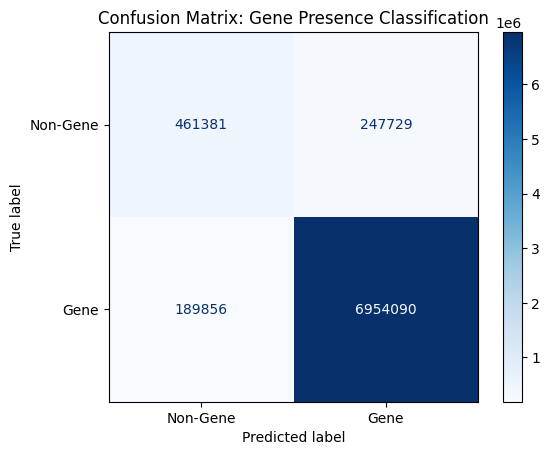

In [72]:
# # Evaluation for gene detection
# Step 1: Run predictions on eval dataset
predsPresence = trainerPresence.predict(evalDatasetPresence)

# Step 2: Extract raw logits and labels
logits = predsPresence.predictions  # shape: (batch_size, sequence_length, num_labels)
trueLabels = predsPresence.label_ids  # shape: (batch_size, sequence_length)

# Step 3: Convert logits to predicted classes
predictions = np.argmax(logits, axis=-1)  # shape: (batch_size, sequence_length)

# Step 4: Flatten everything to 1D (optional masking if needed)
flatPreds = predictions.flatten()
flatLabels = trueLabels.flatten()

# Step 5: Compute metrics
acc = accuracy_score(flatLabels, flatPreds)
precision, recall, f1, _ = precision_recall_fscore_support(flatLabels, flatPreds, average='binary')

print("📊 Final Evaluation Metrics:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

# Step 6: Plot confusion matrix
cm = confusion_matrix(flatLabels, flatPreds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Gene", "Gene"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix: Gene Presence Classification")
plt.show()


In [ ]:
# Move original model to CPU
genePresenceModel = genePresenceModel.to("cpu")  # move it off when not in use
torch.cuda.empty_cache()


In [ ]:
kmers, labelsType = zip(*labelsListForGeneType)
kmersTrainType, kmersEvalType, labelsTrainType, labelsEvalType = train_test_split(kmers, labelsType, test_size=0.2, random_state=42)

allLabels = []
for label in labelsType:
    if label == set():
        allLabels.append([])
    else:
        allLabels.append(list(label))
            
# Binarize labels for y
multiHotBinarizer = MultiLabelBinarizer(classes=allTypes)  # Fix the class order
multiHotLabels = multiHotBinarizer.fit_transform(allLabels)  # Shape: (umKmers, numTypes)

# Step 1: Get label frequency for each class (column)
labelCounts = np.sum(multiHotLabels, axis=0)
# Step 2: Identify columns with at least one positive label
nonzeroIndices = np.where(labelCounts > 0)[0]
# Step 3: Filter the multi-hot labels
multiHotLabels = multiHotLabels[:, nonzeroIndices]
# Step 4: Filter the class labels to match
multiHotBinarizer.classes_ = multiHotBinarizer.classes_[nonzeroIndices]

# trainDatasetType = GeneTypeDataset(kmersTrainType, labelsTrainType, tokenizer)
# evalDatasetType = GeneTypeDataset(kmersEvalType, labelsEvalType, tokenizer)

geneTypeModel = BertForTokenClassification.from_pretrained("zhihan1996/DNA_bert_6", num_labels=len(stilldeciding), problem_type="multi_label_classification")
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Device: {device}")
if device == "cuda":
    geneTypeModel = geneTypeModel.to(device)
